In [1]:
% matplotlib inline
import cv2
import torch
import numpy as np
from PIL import Image
from random import randint
import matplotlib.pyplot as plt 
from torchvision.transforms import ToTensor, ToPILImage

# Discussion of implementation details

In this notebook, I discuss some small but important details.

## contents
1. [Problems of YCbCr in PIL](#problem_of_pil)
2. [Basic Image Processing by Pytorch](#pytorch)
3. [Data Augmentation](#data_augmentation)

shape of img:   (360, 248, 3) | max: 255, min: 0


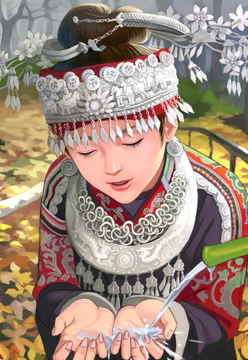

In [2]:
# load a sample image
file = 'figs/test2.png'
img_pil = Image.open(file)
img = np.array(img_pil)
print('shape of img: %15s | max: %d, min: %d' % (str(img.shape), img.max(), img.min()))
img_pil

<a id='problem_of_pil'></a>
## Problems of YCbCr in PIL

From [SRCNN](http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf), standard metrics like **PSNR** and **SSIM** are evaluated on **Y channel** (luminance) in **YCrCb color space**. However, the way to transform from RGB to YCrCb is different from implemntaions. Especially, the value computed by the python package **PIL** will slightly **lower than the benchmark**, which is computed by matlab toolbox. The reason is the differences in the coefficients. Hence, if we want keep all code in python, we need to write the transformation function by ourself.

### convert by PIL

shape of img_ycbcr: (360, 248, 3)   | max: 255, min: 6
shape of img_y:     (360, 248)      | max: 255, min: 6


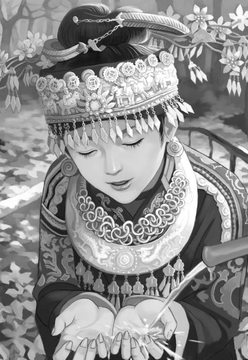

In [3]:
# convert by PIL
img_pil_ycbcr = img_pil.convert('YCbCr')
img_ycbcr = np.array(img_pil_ycbcr)
print('shape of img_ycbcr: %-15s | max: %d, min: %d' % (str(img_ycbcr.shape), img_ycbcr.max(), img_ycbcr.min()))

# display Y channel
img_y = img_ycbcr[:, :, 0]
img_y_pil = Image.fromarray(img_y, "L")
print('shape of img_y:     %-15s | max: %d, min: %d' % (str(img_y.shape), img_y.max(), img_y.min()))
img_y_pil

### convert by customized function

You can find that the result would be slightly different. Additionally, the value computed by the customized function is closer to the [benchmarks](https://github.com/huangzehao/Super-Resolution.Benckmark) than the PIL (Note that it's still not the same).

(360, 248)
shape of img_y_: (360, 248)      | max: 235, min: 21


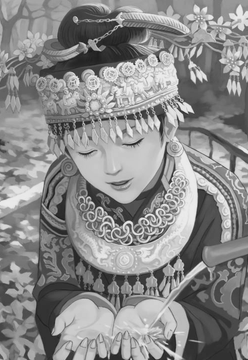

In [4]:
# customized function
def rgb2ycbcr(rgb):
    # reference: https://imxieyi.com/2018/03/24/在python中正确地将rgb转换成ycbcr/
    m = np.array([[65.481, 128.553, 24.966],
                  [-37.797, -74.203, 112.0],
                  [112.0, -93.786, -18.214]])
    shape = rgb.shape
    if len(shape) == 3:
        rgb = rgb.reshape((shape[0] * shape[1], 3))
    ycbcr = np.dot(rgb, m.transpose() / 255.)
    ycbcr[:,0] += 16.
    ycbcr[:,1:] += 128.
    return ycbcr.reshape(shape)
 
# convert
img_y_ = rgb2ycbcr(img)[:, :, 0]

# display Y channel
print(img_y_.shape)
print('shape of img_y_: %-15s | max: %d, min: %d' % (str(img_y_.shape), img_y_.max(), img_y_.min()))
# plt.imshow(img_y_, cmap='gray')
# plt.title('matplotlib')
Image.fromarray(np.uint8(img_y_), "L")

<a id='pytorch'></a>
# Basic Image Processing by Pytorch

If you are a newcomer of Pytorch (like me), you probably want to know how to use some powerful functions to process images. Here are some little demos.

## ToTensor
In torchvision, it provides bunch of useful function to process images. **ToTensor** is design to load PIL object and convert it into the tensor. Note that Pytorch is **channel first** (different form TenserFlow).

The value range of **PIL** is **(0, 255)** but the output tensor of ToTensor is **(0, 1)**.

In [5]:
# original image
print('{:=^40}'.format(' Original '))
img_tensor = ToTensor()(img_pil)
print('        shape of PIL:', np.array(img_pil).shape)
print('shape after ToTensor:', tuple(img_tensor.size()))
print(img_tensor.max().item(), img_tensor.min().item())

# Y channel
print('\n{:=^40}'.format(' Y channel '))
img_y_tensor = ToTensor()(img_y_pil)
print('        shape of PIL:', img_y_pil.size)
print('shape after ToTensor:', tuple(img_y_tensor.size()))

print(img_y_tensor.max().item(), img_y_tensor.min().item())

=============== Original ===============
        shape of PIL: (360, 248, 3)
shape after ToTensor: (3, 360, 248)
1.0 0.0

============== Y channel ===============
        shape of PIL: (248, 360)
shape after ToTensor: (1, 360, 248)
1.0 0.0235294122248888


Next, you can convert tensor back to PIL image, or even numpy array.

In [6]:
img_re_pil = ToPILImage()(img_tensor)
print(np.array(img_re_pil).shape)

(360, 248, 3)


## Clip Values
If you didn't bound the output of networks by activation functions like tanh or sigmoid, the clipping function is needed. Otherwise, it will appear some defects. 

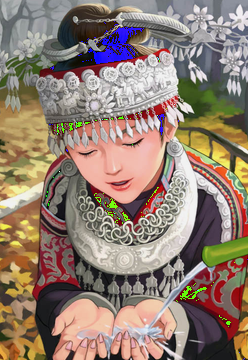

In [7]:
img_tensor_sub = img_tensor - 0.05
img_re_pil_sub = ToPILImage()(img_tensor_sub)
img_re_pil_sub

0.949999988079071 0.0


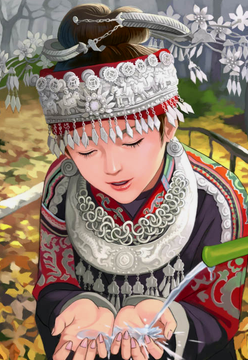

In [8]:
img_tensor_sub_clip = torch.clamp(img_tensor_sub, min=0.0, max=1.0)
print(img_tensor_sub_clip.max().item(), img_tensor_sub_clip.min().item())
img_re_pil_sub_clip = ToPILImage()(img_tensor_sub_clip)
img_re_pil_sub_clip

<a id='data_augmentation'></a>
# Data Augmentation

I only show some common augmentation methods: resizing, flipping, roatation and blurring.

When in **training stage** or using **self-ensembled** [1][2] in **testing stage**, we need flipping operations. <br/>
When creating a customized datasets, we need resize and blur function to simulate the real world sotuations.

[1] Seven ways to improve example-based single image super resolution: https://arxiv.org/pdf/1511.02228.pdf <br/>
[2] Enhanced Deep Residual Networks for Single Image Super-Resolution (EDSR): https://arxiv.org/pdf/1707.02921.pdf (self-ensemble)

### contents
* [Flipping & Rotation](#flip_rot)
* [Resizing](#resizing)
* [Blurring](#blurring)


<a id='flip_rot'></a>
## Flipping & Rotation

In [9]:
def flip_vert(img):
    return img[::-1, :, :]

def flip_hori(img):
    return img[:, ::-1, :]

def rot(img, k=1):
    return np.rot90(img, k)

def augment_random(img):
    para_list = [(0,0), (0,1), (0,2), (0,3),
                 (1,0), (1,1), (1,2), (1,3)]
    rand = randint(0, 7)
    p, k = para_list [rand]
    if p:
        img = flip_vert(img)
    return rot(img, k), rand

def augment_all(img):
    para_list = [(0,0), (0,1), (0,2), (0,3),
                 (1,0), (1,1), (1,2), (1,3)]
    proc_list = []
    for p, k in para_list:
        if p:
            proc_img = flip_vert(img)
        else: 
            proc_img = img[:, :, :]
        proc_list.append(rot(proc_img, k))
    return proc_list

def self_ensemble(aug_list):
    # inverse of augment
    para_list = [(0,0), (0,3), (0,2), (0,1),
                 (1,0), (1,1), (1,2), (1,3)]
    proc_list = []
    sum_all = np.zeros_like(aug_list[0], dtype=float)
    for idx, (p, k) in enumerate(para_list):
        img = aug_list[idx]
        if p:
            proc_img = flip_vert(img)
        else: 
            proc_img = img
        result = rot(proc_img, k)
        sum_all = np.add(sum_all, result)
        proc_list.append(result)
    return sum_all/8.0, proc_list

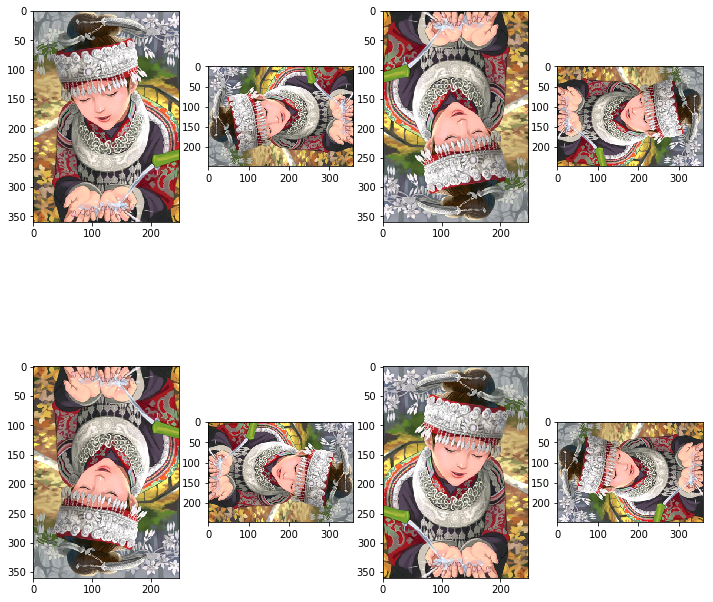

In [10]:
import matplotlib as mpl

# proc
proc_list = augment_all(img)

# plot
mpl.rcParams['figure.figsize'] = (12, 12)
row = 4
for cnt in range(8):
    plt.subplot('24'+str(cnt+1))
    plt.imshow(proc_list[cnt])

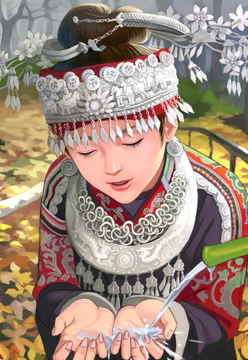

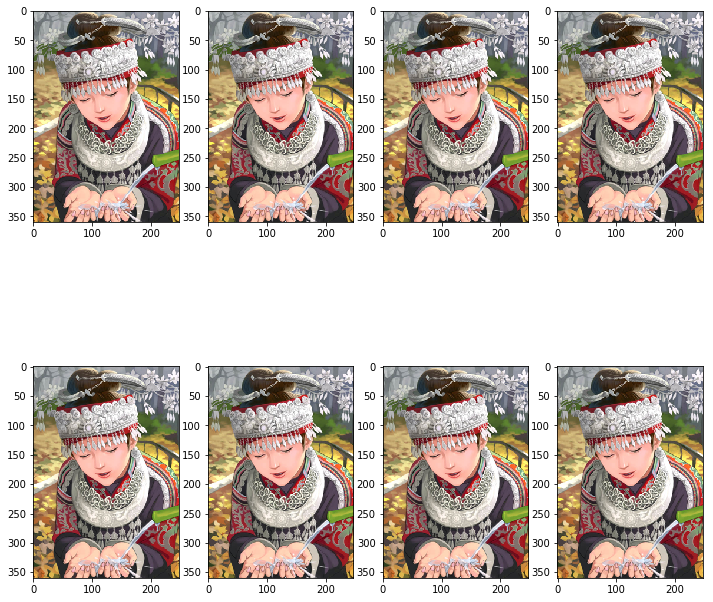

In [16]:
# plot each
ensemble, proc_list_ = self_ensemble(proc_list)
mpl.rcParams['figure.figsize'] = (12, 12)
row = 4
for cnt in range(8):
    plt.subplot('24'+str(cnt+1))
    plt.imshow(proc_list_[cnt])
    
# show result of ensmeble
# Note that when converting a 'float' result to RGB, please convert to uint8 first.
Image.fromarray(np.uint8(ensemble), "RGB")

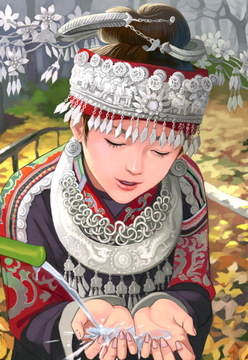

In [12]:
img_hori = flip_hori(img)
Image.fromarray(img_hori, "RGB") # horizontal == vertical flip + rot 180

4


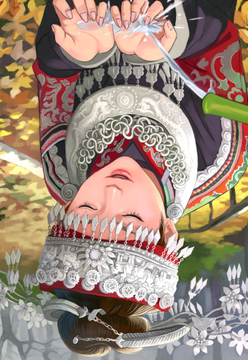

In [13]:
rand_img, rand = augment_random(img)
print(rand)
Image.fromarray(rand_img, "RGB")

<a id='resizing'></a>
## Resizing
Resize in PIL: https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize

* PIL.Image.NEAREST
* PIL.Image.BILINEAR
* PIL.Image.BICUBIC
* PIL.Image.LANCZOS   *(best quality)*

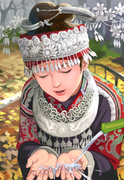

In [14]:
scale = 2
w, h = img_pil.size
img_pil.resize( (w//scale, h//scale), Image.LANCZOS)

## Blurring

<a id='blurring'></a>
Blur an image by Gaussian filter. 

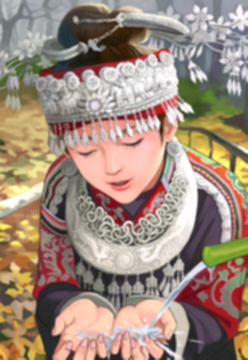

In [15]:
kernel = 3
sigma = 1.6
img_blur = cv2.GaussianBlur(img, (kernel, kernel), sigma)
Image.fromarray(np.uint8(img_blur), "RGB")